<a href="https://colab.research.google.com/github/Nikhil5566/Machine-Learning/blob/main/Deep_Learning_Brain_Tumor_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [3]:
# Installing Kaggle API
!pip install -q kaggle

# Uploading kaggle.json
from google.colab import files
files.upload()

# Moving kaggle.json to ~/.kaggle/
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Downloading the dataset using Kaggle API
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

# Unziping the downloaded file
!unzip brain-mri-images-for-brain-tumor-detection.zip

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor

# Task
Analyze the "brain-mri-images-for-brain-tumor-detection" dataset from "https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection", apply CNN and VGG16 models for brain tumor detection, and compare their performance.

## Load and preprocess data

### Subtask:
Load the images, split the dataset into training and testing sets, and create data generators for image augmentation and batching.


**Reasoning**:
Define the base directory, create file paths and labels, create a DataFrame, split the data into training and testing sets, and initialize ImageDataGenerators for training and testing.



In [4]:
BASE_DIR = '/content/brain_tumor_dataset'
image_paths = []
labels = []

for label in ['no', 'yes']:
    path = os.path.join(BASE_DIR, label)
    for file in os.listdir(path):
        image_paths.append(os.path.join(path, file))
        labels.append(label)

df = pd.DataFrame({'filepath': image_paths, 'label': labels})

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


## Visualize Sample Images

### Subtask:
Display a few sample images from each class ('yes' and 'no') to get a visual understanding of the dataset.

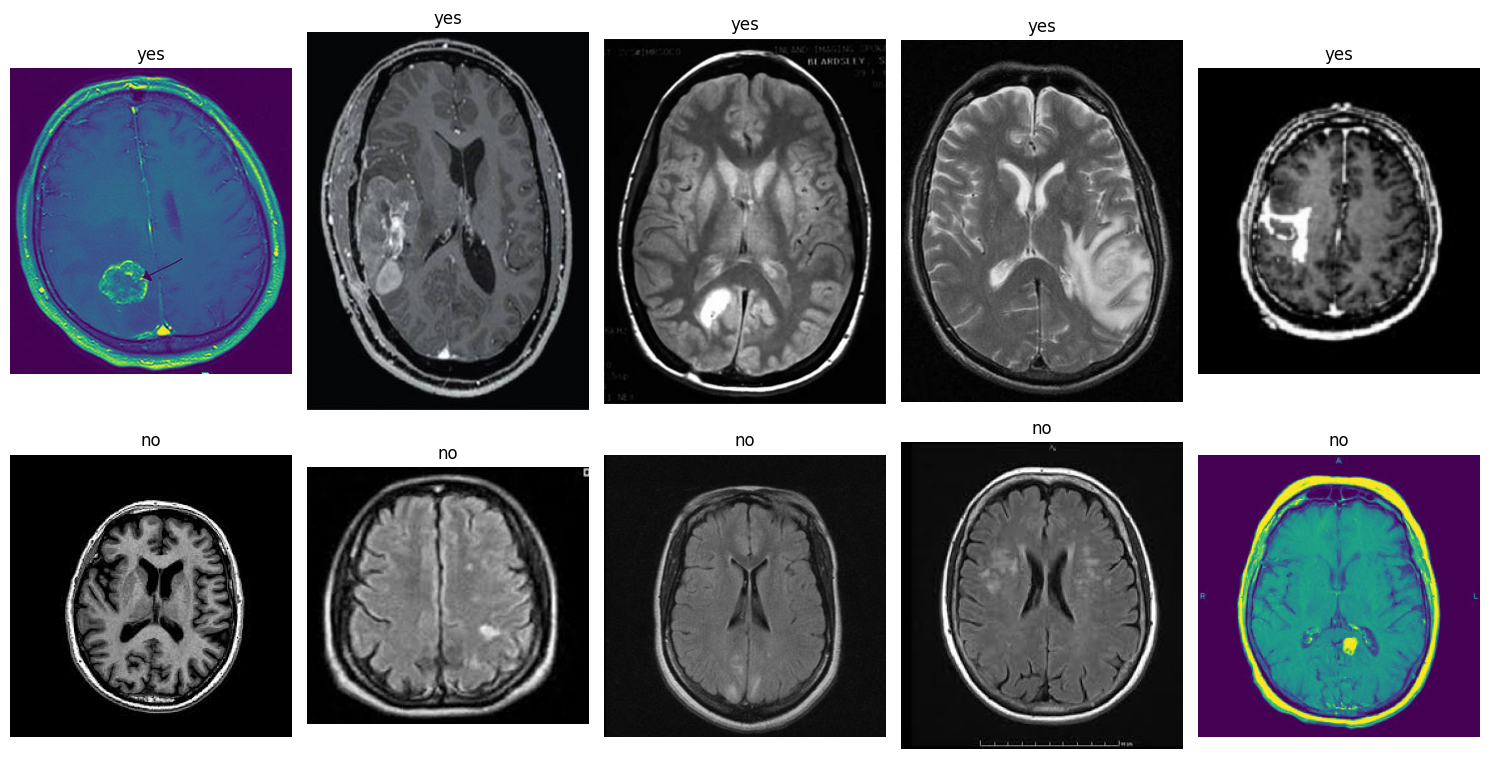

In [10]:
# Select a few sample images from each class
sample_yes = df[df['label'] == 'yes'].sample(5)
sample_no = df[df['label'] == 'no'].sample(5)

# Combine the samples
sample_images = pd.concat([sample_yes, sample_no])

# Display the images
plt.figure(figsize=(15, 8))
for i, row in enumerate(sample_images.itertuples()):
    plt.subplot(2, 5, i + 1)
    img = plt.imread(row.filepath)
    plt.imshow(img)
    plt.title(row.label)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Build and train cnn model

## Subtask:
Define a Convolutional Neural Network (CNN) model, compile it, and train it on the prepared data.


**Reasoning**:
Define and compile the CNN model, define callbacks, and train the model.



In [5]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_model.keras', monitor='val_loss', save_best_only=True)

cnn_history = cnn_model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6119 - loss: 0.9145 - val_accuracy: 0.6863 - val_loss: 0.6148
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6705 - loss: 0.6266 - val_accuracy: 0.6863 - val_loss: 0.6065
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6224 - loss: 0.6621 - val_accuracy: 0.7059 - val_loss: 0.5569
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7470 - loss: 0.5778 - val_accuracy: 0.8431 - val_loss: 0.4763
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7053 - loss: 0.6175 - val_accuracy: 0.7451 - val_loss: 0.4768
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6864 - loss: 0.6200 - val_accuracy: 0.7451 - val_loss: 0.4701
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7427 - loss: 0.5515 - val_accuracy: 0.8235 - val_loss: 0.4159
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 979ms/step - accuracy: 0.7244 - loss: 0.5531 - val_accuracy: 0.7451 - val_loss: 0.4859
Epoch 9/50


# Build and train vgg16 model

## Subtask:
Load the pre-trained VGG16 model, add custom layers for classification, compile the model, and train it on the prepared data.


**Reasoning**:
Load the pre-trained VGG16 model, add custom layers, compile the model, and train it as per the instructions.



In [6]:
# Load the pre-trained VGG16 model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the layers
for layer in vgg_base.layers:
    layer.trainable = False

# Create a new Sequential model
vgg_model = Sequential()
vgg_model.add(vgg_base)

# Add custom classification layers
vgg_model.add(Flatten())
vgg_model.add(Dense(128, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(1, activation='sigmoid'))

# Compile the model
vgg_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_vgg16_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
vgg_history = vgg_model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 53s 7s/step - accuracy: 0.5497 - loss: 0.8428 - val_accuracy: 0.6078 - val_loss: 0.6254
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 7s/step - accuracy: 0.5110 - loss: 0.7461 - val_accuracy: 0.8039 - val_loss: 0.5260
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 7s/step - accuracy: 0.7152 - loss: 0.6170 - val_accuracy: 0.7451 - val_loss: 0.4892
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - accuracy: 0.6854 - loss: 0.5824 - val_accuracy: 0.8824 - val_loss: 0.4388
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 8s/step - accuracy: 0.7478 - loss: 0.4692 - val_accuracy: 0.8627 - val_loss: 0.4173
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 7s/step - accuracy: 0.7445 - loss: 0.5251 - val_accuracy: 0.8824 - val_loss: 0.3990
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - accuracy: 0.8110 - loss: 0.4582 - val_accuracy: 0.8824 - val_loss: 0.3801
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 7s/step - accuracy: 0.8207 - loss: 0.4393

# Evaluate models

### Subtask:
Evaluate the performance of both the CNN and VGG16 models using appropriate metrics like accuracy, precision, recall, and F1-score.


**Reasoning**:
Load the saved models, make predictions on the test set, and evaluate their performance using classification reports and confusion matrices.



In [7]:
# Load the best saved CNN model
cnn_model = load_model('best_cnn_model.keras')

# Load the best saved VGG16 model
vgg_model = load_model('best_vgg16_model.keras')

# Predict the classes for the test set
cnn_predictions = cnn_model.predict(test_generator)
vgg_predictions = vgg_model.predict(test_generator)

# Convert predictions to binary classes
cnn_predicted_classes = (cnn_predictions > 0.5).astype(int)
vgg_predicted_classes = (vgg_predictions > 0.5).astype(int)

# Get true labels
true_labels = test_generator.classes

# Generate and print classification report for CNN
print("CNN Model Performance:")
print(classification_report(true_labels, cnn_predicted_classes, target_names=test_generator.class_indices.keys()))

# Generate and print confusion matrix for CNN
print("CNN Confusion Matrix:")
print(confusion_matrix(true_labels, cnn_predicted_classes))

# Generate and print classification report for VGG16
print("\nVGG16 Model Performance:")
print(classification_report(true_labels, vgg_predicted_classes, target_names=test_generator.class_indices.keys()))

# Generate and print confusion matrix for VGG16
print("VGG16 Confusion Matrix:")
print(confusion_matrix(true_labels, vgg_predicted_classes))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step
CNN Model Performance:
              precision    recall  f1-score   support

          no       0.85      0.85      0.85        20
         yes       0.90      0.90      0.90        31

    accuracy                           0.88        51
   macro avg       0.88      0.88      0.88        51
weighted avg       0.88      0.88      0.88        51

CNN Confusion Matrix:
[[17  3]
 [ 3 28]]

VGG16 Model Performance:
              precision    recall  f1-score   support

          no       0.90      0.95      0.93        20
         yes       0.97      0.94      0.95        31

    accuracy                           0.94        51
   macro avg       0.94      0.94      0.94        51
weighted avg       0.94      0.94      0.94        51

VGG16 Confusion Matrix:
[[19  1]
 [ 2 29]]


## Visualize results

### Subtask:
Visualize the training progress and evaluation results to compare the performance of the two models.


**Reasoning**:
Plot the training and validation accuracy and loss for both models to visualize their performance during training.



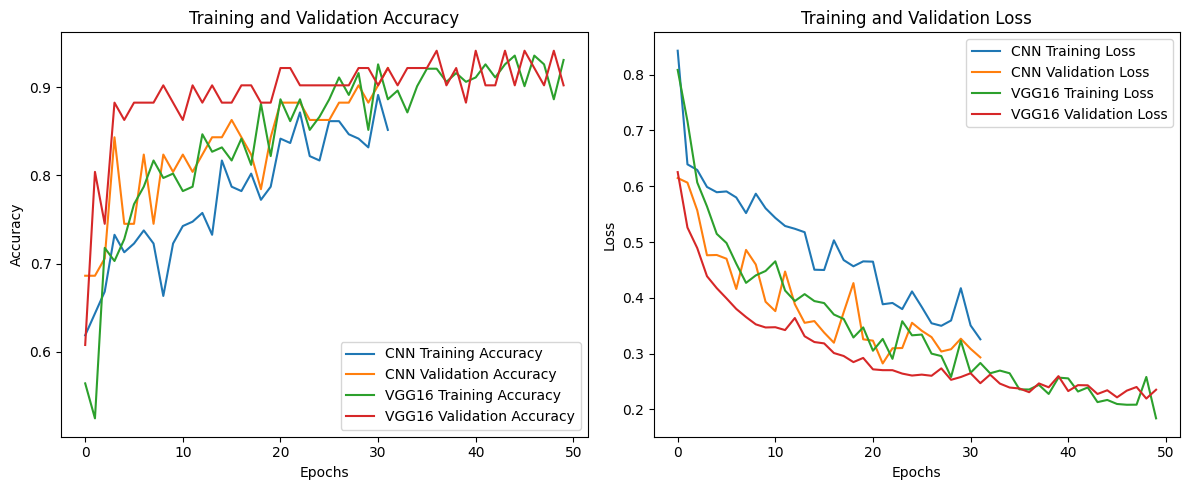

In [8]:
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.plot(vgg_history.history['accuracy'], label='VGG16 Training Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='CNN Training Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss')
plt.plot(vgg_history.history['loss'], label='VGG16 Training Loss')
plt.plot(vgg_history.history['val_loss'], label='VGG16 Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Visualize Confusion Matrices

### Subtask:
Visualize the confusion matrices for both CNN and VGG16 models using heatmaps.

**Reasoning**:
Generate heatmaps for the confusion matrices of both models to visually represent their performance in terms of true positives, true negatives, false positives, and false negatives.

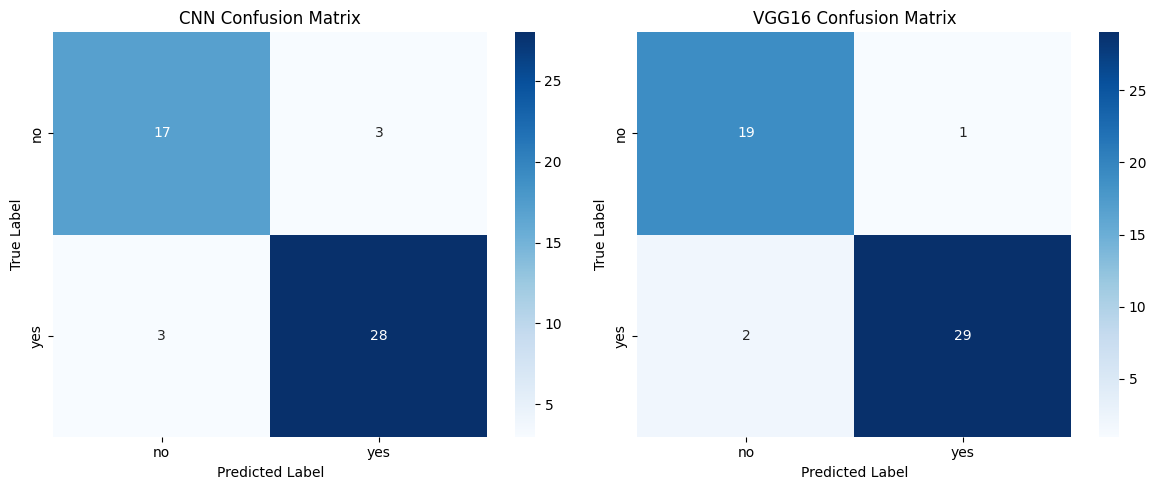

In [17]:
# Generate confusion matrices
cnn_cm = confusion_matrix(true_labels, cnn_predicted_classes)
vgg_cm = confusion_matrix(true_labels, vgg_predicted_classes)

# Get class names
class_names = test_generator.class_indices.keys()

plt.figure(figsize=(12, 5))

# Plot confusion matrix for CNN
plt.subplot(1, 2, 1)
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Plot confusion matrix for VGG16
plt.subplot(1, 2, 2)
sns.heatmap(vgg_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('VGG16 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

## Visualize Evaluation Results with Bar Graphs

### Subtask:
Create bar graphs to compare the key performance metrics (accuracy, precision, recall, F1-score) of the CNN and VGG16 models.

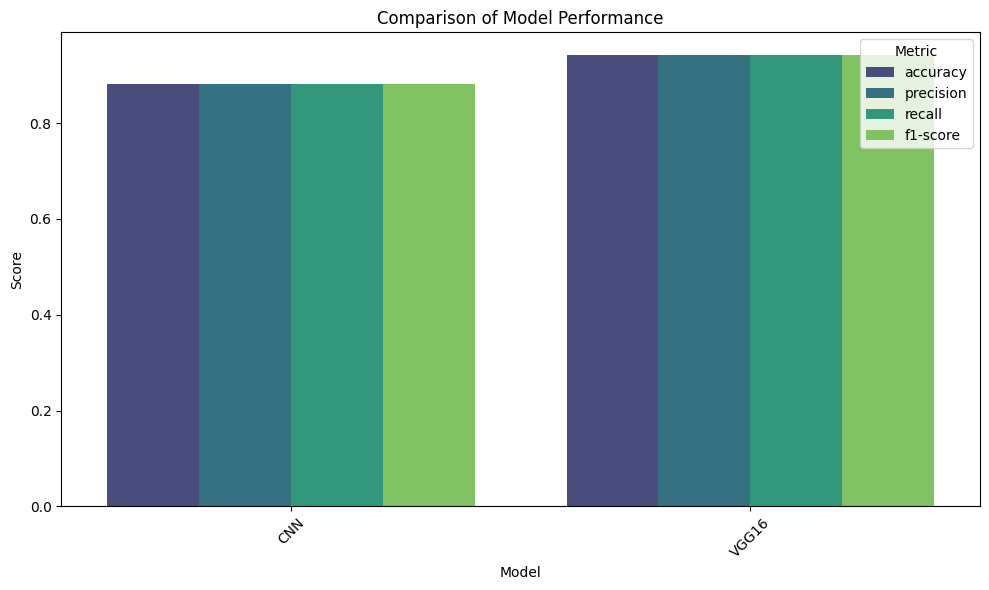

In [16]:
# Create a DataFrame for comparison
comparison_data = {
    'Model': ['CNN'] * len(metrics) + ['VGG16'] * len(metrics),
    'Metric': metrics * 2,
    'Value': cnn_scores + vgg_scores
}
comparison_df = pd.DataFrame(comparison_data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Value', hue='Metric', data=comparison_df, palette='viridis')
plt.title('Comparison of Model Performance')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

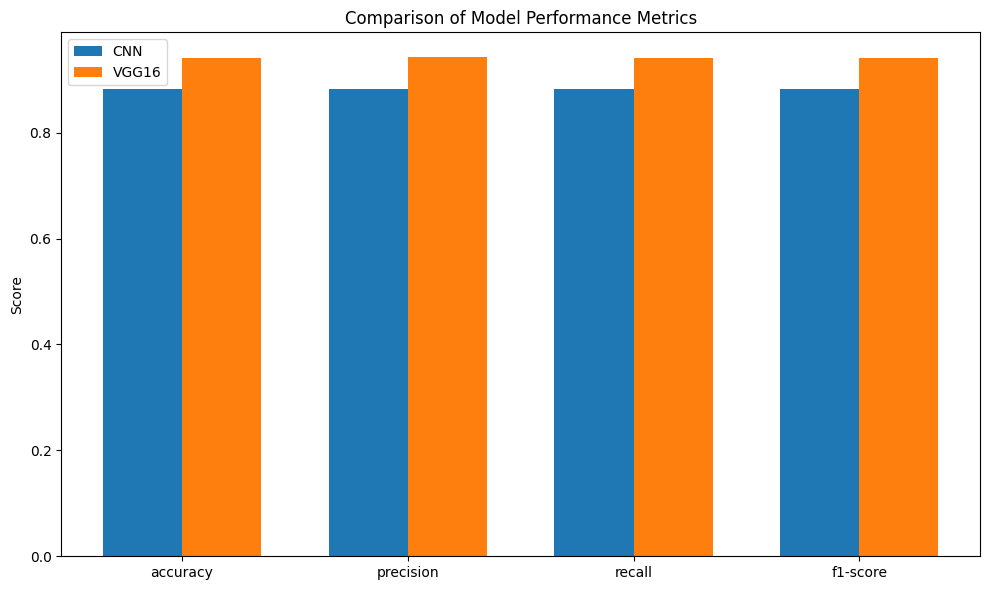

In [14]:
# Extract metrics from the classification reports
cnn_report = classification_report(true_labels, cnn_predicted_classes, target_names=test_generator.class_indices.keys(), output_dict=True)
vgg_report = classification_report(true_labels, vgg_predicted_classes, target_names=test_generator.class_indices.keys(), output_dict=True)

metrics = ['accuracy', 'precision', 'recall', 'f1-score']
cnn_scores = [cnn_report['accuracy'], cnn_report['weighted avg']['precision'], cnn_report['weighted avg']['recall'], cnn_report['weighted avg']['f1-score']]
vgg_scores = [vgg_report['accuracy'], vgg_report['weighted avg']['precision'], vgg_report['weighted avg']['recall'], vgg_report['weighted avg']['f1-score']]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, cnn_scores, width, label='CNN')
rects2 = ax.bar(x + width/2, vgg_scores, width, label='VGG16')

ax.set_ylabel('Score')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The dataset was split into 80% for training and 20% for testing, with stratification to maintain class distribution.
*   Image data generators were used for both training and testing, incorporating augmentation (shear, zoom, horizontal flip) for the training data and only rescaling for both.
*   A custom CNN model was built with multiple convolutional and pooling layers, followed by dense layers and a dropout layer for regularization.
*   A VGG16 model was used with pre-trained weights from ImageNet, with its convolutional base frozen and custom dense layers added for the binary classification task.
*   Both models were trained using the Adam optimizer and binary crossentropy loss. Early stopping and model checkpointing were implemented to optimize training and save the best models.
*   The VGG16 model achieved a higher overall accuracy (0.94) compared to the custom CNN model (0.88) on the test set.
*   The VGG16 model showed better performance in both identifying tumors (recall for 'yes' was 0.94 for VGG16 vs. 0.90 for CNN) and correctly classifying images without tumors (recall for 'no' was 0.95 for VGG16 vs. 0.85 for CNN).
*   The confusion matrices indicate that the VGG16 model had fewer false positives (1) and false negatives (2) than the CNN model (3 false positives and 3 false negatives).
*   The training and validation accuracy and loss curves were plotted, visually representing the learning progress and convergence of both models.

### Insights or Next Steps

*   The superior performance of the VGG16 model suggests that leveraging pre-trained models and transfer learning is highly effective for this image classification task, likely due to the model's ability to capture complex image features.
*   Further experimentation could involve fine-tuning the later layers of the VGG16 model instead of freezing the entire base, or exploring other pre-trained architectures to potentially improve performance further.
